# CLML Time Series Tutorial Part 1

> (C) 2015 Mike Maul -- CC-BY-SA 3.0

This document is a the first is a series of tutorials illustrating the use of the CLML.time-series package. In fact it is a first in a series of series of tutorials illustrating the use of CLML. 

###Caveat
Anyone wishing to run this notebook or the code contained there in must take note of the following:
  - This time series cleaning section of this tutorial relies on the github version of [`CLML` https://github.com/mmaul/clml.git](https://github.com/mmaul/clml.git) or a quicklist-dist `CLML`> than 20150805 
  - The plotting portion of this code requires the system [`clml.extras` https://github.com/mmaul/clml.extras.git](https://github.com/mmaul/clml.extras.git) which is not currently in quicklisp.
  - While the above git repositories are not in quicklisp they be loaded by `quickload` by placing the repositories in $HOME/quicklisp/local-projects

## Time Series, what and why 

A time series is a set of data points collected over a given period of time. Examples of time series are stock ticker data, sensor data and netflow data. Generally one wants to preform some sort of analysis on a time series and or use previous performance to forecast future performance or else use past performance to detect anomalies new data. 

The CLML.time-series system contains functionality to manipulate, analyze time series data. CLML.time-series has a definite opinion on what a time-series is. We will see that after we load some data.

Lets get started by loading the system necessary for this tutorial and creating a namespace to work in.


In [1]:
(ql:quickload '(:clml.utility ; Need clml.utility.data to get data from the net
                :clml.hjs ; Need clml.hjs.read-data to poke around the raw dataset
                :clml.time-series ; Need Time Series package obviously
                :iolib
                :clml.extras.eazy-gnuplot
                :eazy-gnuplot
            ))

To load "clml.utility":
  Load 1 ASDF system:
    clml.utility

; Loading "clml.utility"
....
To load "clml.hjs":
  Load 1 ASDF system:
    clml.hjs

; Loading "clml.hjs"

To load "clml.time-series":
  Load 1 ASDF system:
    clml.time-series

; Loading "clml.time-series"

To load "iolib":
  Load 1 ASDF system:
    iolib

; Loading "iolib"
.....
To load "clml.extras.eazy-gnuplot":
  Load 1 ASDF system:
    clml.extras.eazy-gnuplot

; Loading "clml.extras.eazy-gnuplot"

To load "eazy-gnuplot":
  Load 1 ASDF system:
    eazy-gnuplot

; Loading "eazy-gnuplot"



(:CLML.UTILITY :CLML.HJS :CLML.TIME-SERIES :IOLIB :CLML.EXTRAS.EAZY-GNUPLOT
 :EAZY-GNUPLOT)

In [2]:
(defpackage #:time-series-part-2
  (:use #:cl
        #:cl-jupyter-user ; Not needed unless using iPython notebook
        #:clml.time-series.read-data
        #:clml.time-series.anomaly-detection
        #:clml.time-series.exponential-smoothing
        #:clml.extras.eazy-gnuplot)
  (:import-from #:clml.hjs.read-data #:head-points #:!! #:dataset-dimensions)
  (:import-from #:clml.time-series.util #:predict)
  (:import-from #:clml.hjs.read-data #:read-data-from-file)
  )


#<PACKAGE "TIME-SERIES-PART-2">

In [3]:
(in-package :time-series-part-2)

#<PACKAGE "TIME-SERIES-PART-2">

##Data and Datasets

We are going to look at how time series data can be used by CLML.
First lets get some data...


In [4]:
(defparameter dataset (read-data-from-file 
        (clml.utility.data:fetch 
            "https://mmaul.github.io/clml.data/sample/msi-access-stat/access-log-stat.sexp")))

DATASET

CLML's main unit of currency in working with data is the dataset. The dataset is a hierarchy series of classes that contain datapoints and metadata. They are similar to dataframes in R or data-tables in Python.

In [5]:
dataset

#<CLML.HJS.READ-DATA:UNSPECIALIZED-DATASET >
DIMENSIONS: date/time | hits
TYPES:      UNKNOWN | UNKNOWN
NUMBER OF DIMENSIONS: 2
DATA POINTS: 9068 POINTS


CCLML has a number of different specializations of dataset such as
  - `unspecialized-dataset` untyped and unspecialized data
  - `numeric-dataset` dataset containing numeric (`double-float`) data
  - `categor-dataset` dataset for categorical (`string`) data
  - `numeric-and-category-dataset` dataset containing a mixture of numeric and categorical data

Most relevant to this tutorial
  - `time-series-dataset` dataset containing time-series data
  
Datasets can be created directly or can be created by reading them from a file. Supported data formats or CSV and SEXP.
In this case the `read-data-from-file` function is reading a data set from a file. The file in this case is a file that is obtained with the `fetch` function, which downloads and caches a file from a location on a local files system or a URL.

Lets take a look at the data, it apparently is from a hit counter.
`head-points` gives us the first 5 rows of a dataset ( if we wanted all the rows in a dataset we would have used `dataset-points`

In [6]:
(head-points dataset)

#(#("12/May/2008 03:00-03:59" 210) #("12/May/2008 04:00-04:59" 265)
  #("12/May/2008 05:00-05:59" 219) #("12/May/2008 06:00-06:59" 284)
  #("12/May/2008 07:00-07:59" 287))

Examining the data it looks like hits collected hourly. `time-series-datasets` can be created with the `time-series` function. 

Now Lets put this in a turn this into a time-series-dataset so we can do stuff with it.

In [7]:
(defparameter msi-access (time-series-data dataset :range '(1) :time-label 0 :frequency 24 :start '(18 3)))

MSI-ACCESS

In [8]:
msi-access

#<TIME-SERIES-DATASET >
DIMENSIONS: hits
TYPES:      NUMERIC
NUMBER OF DIMENSIONS: 1
FREQUENCY:  24
START:      (18 3)
END:        (395 22)
POINTS:     9068
TIME-LABEL: date/time


This is the point where we will talk about CLML.time-series's definite opinions about time series. Time series in CLML.time-series are [discrete](https://en.wikipedia.org/wiki/Discrete_time_and_continuous_time). In `CLML.time-series`'s opinion time series have a regular frequency. (This implies that time series data must have a reading at each period. However `CLML.time-series` does support missing values which will be covered in a later part of this series) The representation of frequency is a important, especially when comparing time-series points at regular intervals. The `FREQUENCY` slot specifies the number of datapoints per cycle. The `START` slot indicates the starting time index and frequency interval. The measurements are contained in the points slot and are represented as a vector of `ts-point` objects. Another useful thing to know is the slot accessor prefix is `ts-`

In fact in the dataset we just created if you look at the raw dataset above you will see there are no time specifiers in the data (there are labels however but they are not used in computations). This can actually be very important if your time-series has literally astronomical ranges. Some time-series libraries/databases encode the index as seconds or milliseconds from some fixed point in time. Doing that then constricts the ability of the time series to represent times to the range of the datatype being used to encode the time index. To be fair CLML.time-series in effect is doing the same thing however the time index is relative and the time indices can range from 0 to `most-positive-fixnum` (~4.6e18 in SBCL) given a datapoint is defined by the time and frequency interval (which also range from 0 to `most-positive-fixnum` the number of theoretically possible datapoints in a time series is `most-positive-fixnum` squared (in SBCL this would be greater than 2.0e35)

Lets look at the points in the dataset to see how they are represented.

In [9]:
(subseq(ts-points msi-access) 0 5)

#(#S(CLML.TIME-SERIES.READ-DATA::TS-POINT
     :TIME 18
     :FREQ 3
     :LABEL "12/May/2008 03:00-03:59"
     :POS #(210.0d0))
  #S(CLML.TIME-SERIES.READ-DATA::TS-POINT
     :TIME 18
     :FREQ 4
     :LABEL "12/May/2008 04:00-04:59"
     :POS #(265.0d0))
  #S(CLML.TIME-SERIES.READ-DATA::TS-POINT
     :TIME 18
     :FREQ 5
     :LABEL "12/May/2008 05:00-05:59"
     :POS #(219.0d0))
  #S(CLML.TIME-SERIES.READ-DATA::TS-POINT
     :TIME 18
     :FREQ 6
     :LABEL "12/May/2008 06:00-06:59"
     :POS #(284.0d0))
  #S(CLML.TIME-SERIES.READ-DATA::TS-POINT
     :TIME 18
     :FREQ 7
     :LABEL "12/May/2008 07:00-07:59"
     :POS #(287.0d0)))

he `ts-point` class encodes each measurement maintaining the time and frequency interval, a label (which is just a string, ad the actual measurements. The measurements in the `pos` slot are stored in a vector arbitrary length. Looking back to **IN[8]** you can see when we gave `time-series` a start time of 18 , and a start frequency interval of 3 we can see by examining the `ts-points`s how this is actually represented. Another useful thing to know is that the accessor prefix of `ts-point` is `ts-s-`

`time-series-datasets` can also be created programattically.
Some examples are:

    (make-constant-time-series-data  '("a") (vector (clml.hjs.meta:make-dvec 1)))
    (make-constant-time-series-data '("price") (vector (v2dvec #(43.2d0)) (v2dvec #(44.0d0)) (v2dvec #(1049.0d0))))

## Plotting Datasets   

Lets plot our data with the `clml.extras.eazy-gnuplot:plot-dataset`. 

Some quick things to note about the `plot-dataset` method:
  - The only required arguments are `dataset` and `y-col`
  - The terminal defaults to `:wxt :persist` so for use in a notebook we specify a **PNG** terminal
  - The `svg` function is used to render the plot in the notebook
  - `eazy-gnuplot` is used as the plotting library all plotting arguments follow gnuplot and `eazy-gnuplot`'s conventions
  - The `:range` argument specifies the start and end of the points to display
  - The `:frequencies` argument is a list of frequencies to plot, handy for observing behavior over specific intervals.


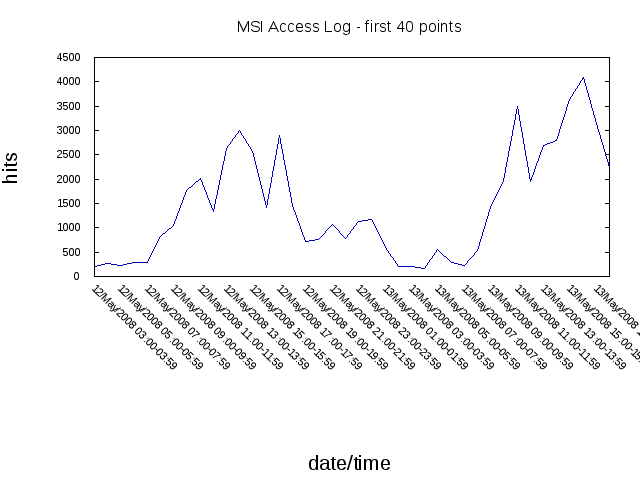

In [10]:
(progn
    (plot-dataset msi-access "hits" :terminal '(:png)
        :range '(0 40) :title "MSI Access Log - first 40 points" :ytics-font ",8" :xtics-font ",8"
        :xlabel-font ",15" :ylabel-font ",15" :output "msi_access_log_40.png")
        (display-png (png-from-file "msi_access_log_40.png")))

Now lets look at the whole dataset. Since each `ts-point` has a label our x axis would get overwhelmed with labels, we use the `:xtic-interval` to specify that we only want labels displayed every 500 points.

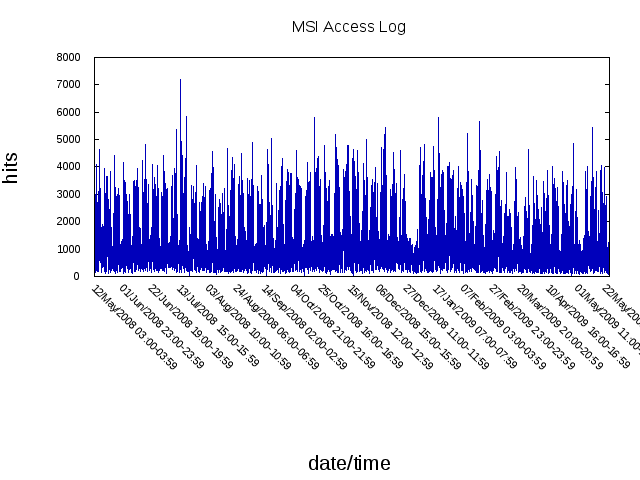

In [13]:
(progn
 (plot-dataset msi-access "hits" :terminal '(:png )
        :title "MSI Access Log" :ytics-font ",8" :xtics-font ",8"
        :xlabel-font ",15" :ylabel-font ",15" :xtic-interval 500 :output "msi_access_log.png")
 (display-png (png-from-file "msi_access_log.png")))

##Cleaning Datasets

Sometimes data may have missing values or outliers. It is not unusual to have a broken or malfunctioning sensor generating your data. We have a way of dealing with that.

The `time-series-dataset` class has a `ts-cleaning` method which can clean missing values an outliers. Lets look at the documentation:

    TS-CLEANING names a generic function:
      Lambda-list: (D &KEY)
      Derived type: (FUNCTION (T &KEY) *)
      Documentation:
        - return: <time-series-dataset>
        - arguments:
            - d : <time-series-dataset>
            - interp-types-alist: 
                 a-list (key: column name, datum: interpolation(:zero :min :max :mean :median :mode :spline)) | nil
            - outlier-types-alist: 
                 a-list (key: column name, datum: outlier-verification(:std-dev :mean-dev :user :smirnov-grubbs 
                              :freq)) | nil
            - outlier-values-alist : 
                 a-list (key: outlier-verification datum: the value according to outlier-verification) | nil
       - comment:
           Same as /dataset-cleaning/ in read-data package.

Lets give it a try. In particular lets set the threshold for outliers to 5 standard deviations and set the interpolation method to mean.

In [15]:
(defparameter c-msi-access 
    (ts-cleaning msi-access :outlier-types-alist '(("hits" . :std-dev)) 
                            :outlier-values-alist '((:std-dev . 5)) 
                            :interp-types-alist '(("hits" . :mean))))

C-MSI-ACCESS

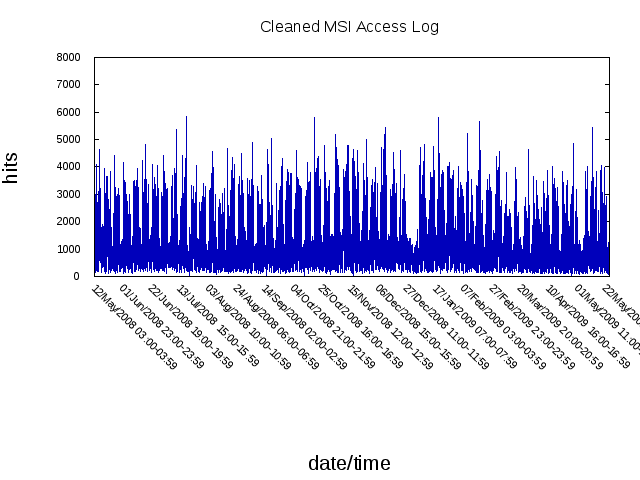

In [16]:
(let ((png-file "clean-msi-access-log")) 
 (plot-dataset c-msi-access "hits" :terminal '(:png)
        :title "Cleaned MSI Access Log" :ytics-font ",8" :xtics-font ",8"
        :xlabel-font ",15" :ylabel-font ",15" :xtic-interval 500
        :yrange '(0 8000) 
        :output png-file)
  (display-png (png-from-file png-file)))

Notice the datapoint near 13 July 2008 15:00 to 15:59 that previously spiked to over 7000, is now more reasonable.

##Conclusion
I would like to thank Fredreric Peschanski the creator of [`fishbowl`](https://github.com/fredokun/fishbowl-repl) which provides common lisp support for iPython. I would also like to thank Masataro Asai the creator of [`eazy-gnuplot`](https://github.com/guicho271828/eazy-gnuplot/). I would like to thank the creators of iPython and project [Jupyter](http://jupyter.org/) a truly cross platform mechanisim for th presentation of code and content. Finally I would like to thank github for [providing the ability to view notebooks inside github repositories] (http://blog.jupyter.org/2015/05/07/rendering-notebooks-on-github/)

The iPython notebook and source for this tutorial can be found in the [clml.tutorials https://github.com/mmaul/clml.tutorials.git](https://github.com/mmaul/clml.tutorials.git) github repository.

###Stay tuned to [clml.tutorials](https://mmaul.github.io/clml.tutorials/) blog or [RSS feed](https://mmaul.github.io/clml.tutorials/feed.xml) for Part II which will cover prediction, anomaly-detection.